# Poisson equation over L-shaped domain - Paddle backend

*Last edited: 2023-07-20*

Source: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.Lshape.html

Poisson equation:

$ - u_{xx}-u_{yy} = 1, \qquad  \Omega = [-1,1]^2 \backslash [0,1]^2 $

and Dirichlet boundary conditions:

$ u(x,y)=0, \qquad (x,y)\in \partial \Omega $

where:
- Ω is the function domain
- ∂Ω is the boundary of the domain

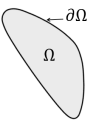
Source: simscale.com

$[-1,1]^2$ is the unit square, while $[0,1]^2$ is the quarter of square that incluides the corner at the origin.

So $ [-1,1]^2 \backslash [0,1]^2 $ is the other three-fourths of the square, a (roughly) ell-shaped region (or exactly the shape of the [L-tromino](https://en.wikipedia.org/wiki/Tromino)). 

[[Source]]( https://math.stackexchange.com/questions/1498639/notation-what-does-0-12-backslash-0-0-52-mean)

First, the DeepXDE module is imported:

In [2]:
%env DDE_BACKEND=paddle
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

env: DDE_BACKEND=paddle


We begin by defining a computational geometry. We can use a built-in class `Polygon` as follows

In [3]:
geom = dde.geometry.Polygon(
    [[0, 0], [1, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]]
)

The geometry in this case is a polygon with six line segments, which is in a L-shape.

Next, we express the PDE residual of the Poisson equation:

In [4]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    f = -dy_xx - dy_yy - 1
    return f

The first argument to `pde` is the network input, i.e., the x-coordinate. The second argument is the network output, i.e., the solution u(x) and we use `y` as the name of the variable.

Next, we consider the Dirichlet boundary condition. A simple Python function, returning a boolean, is used to define the subdomain for the Dirichlet boundary condition. The function should return `True` for those points inside the subdomain and `False` for the points outside. In our case, the points (x,y) of the Dirichlet boundary condition are $ (x,y) \in \partial\{ [-1,1]^2\backslash [0,1]^2 \} $.

In [5]:
def boundary(_, on_boundary):
    return on_boundary

Then, the Dirichlet boundary condition is

In [6]:
bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

Now, we have specified the geometry, PDE residual, and Dirichlet boundary condition. We then define the PDE problem as

In [7]:
data = dde.data.PDE(geom,
                    pde,
                    bc,
                    num_domain=1200,
                    num_boundary=120,
                    num_test=1500)

The number 1200 is the number of training residual points sampled inside the domain, and the number 120 is the number of training points sampled on the boundary. We use 1500 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 5 (i.e., 4 hidden layers) and width 50. Besides, we choose `tanh` as activation function and `Glorot uniform` as initializer :

In [8]:
net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")

W0720 15:32:42.669226 26955 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 6.1, Driver API Version: 12.2, Runtime API Version: 10.2
W0720 15:32:42.674078 26955 gpu_resources.cc:149] device: 0, cuDNN Version: 7.6.


Now, we have the PDE problem and the network. We build a Model and choose the optimizer and learning rate:



In [9]:
model = dde.Model(data, net)

In [10]:
model.compile("adam", lr=0.001)

Compiling model...
'compile' took 0.000635 s



We first train the model for 50000 iterations with Adam optimizer:

In [11]:
model.train(iterations=50000)

Training model...

Step      Train loss              Test loss               Test metric
0         [9.64e-01, 3.13e-01]    [9.62e-01, 3.13e-01]    []  
1000      [1.41e-04, 2.82e-03]    [1.28e-04, 2.82e-03]    []  
2000      [9.86e-05, 2.63e-03]    [8.58e-05, 2.63e-03]    []  
3000      [2.16e-04, 1.95e-03]    [1.59e-04, 1.95e-03]    []  
4000      [3.15e-04, 1.09e-03]    [2.79e-04, 1.09e-03]    []  
5000      [6.71e-04, 5.35e-04]    [7.25e-04, 5.35e-04]    []  
6000      [1.66e-04, 2.85e-04]    [1.84e-04, 2.85e-04]    []  
7000      [7.92e-05, 1.91e-04]    [8.72e-05, 1.91e-04]    []  
8000      [4.65e-05, 1.60e-04]    [4.23e-05, 1.60e-04]    []  
9000      [3.94e-05, 1.41e-04]    [3.65e-05, 1.41e-04]    []  
10000     [1.12e-04, 1.46e-04]    [1.03e-04, 1.46e-04]    []  
11000     [3.61e-05, 1.38e-04]    [3.22e-05, 1.38e-04]    []  
12000     [2.82e-05, 1.28e-04]    [2.73e-05, 1.28e-04]    []  
13000     [7.04e-05, 1.28e-04]    [6.08e-05, 1.28e-04]    []  
14000     [1.73e-04, 1.44e-04

(<deepxde.model.LossHistory at 0x7f17365b9f60>,
 <deepxde.model.TrainState at 0x7f17365b96c0>)

From [1]: 

We remark that based on our experience, for smooth PDE solutions L-BFGS can find a good solution with less iterations than Adam, because L-BFGS uses second-order derivatives of the loss function, while Adam only relies
on first-order derivatives. However, for stiff solutions L-BFGS is more likely to be stuck at a bad local minimum.

We first use Adam for a certain number of iterations, and then switch to L-BFGS. The optimizer L-BFGS does not require learning rate, and the neural network is trained until convergence, so the number of iterations is also ignored for L-BFGS.

From [2]:

In the training phase, an optimization process targeting the residual minimization determines the weights and biases of the surrogate network. Typically, we use two optimizers in succession: the Adam optimizer as first and then a Broyden-Fletcher-Goldfarb-Shanno (BFGS) optimizer [6]. BFGS uses the Hessian matrix (curvature in highly dimensional space) to calculate the optimization direction and provides more accurate results. However, if used directly without using the Adam optimizer can rapidly converge to a local minimum (for the residual) without exiting. For this reason, the Adam optimizer is used first to avoid local minima, and then the solution is refined by BFGS. We note that the typical BFGS used in PINNs is the L-BFGS-B: L-BFGS is a limited-memory version of BFGS to handle problems with many variables, such as DL problems; the BFGS-B is a variant of BFGS for bound constrained optimization problems. In our work, we tested several optimizers, including Newton and Powell methods, and found that L-BFGS-B provides by far the highest accuracy and faster convergence in all our test problems. L-BFGS-B is currently the most critical technology for PINNs.

And then we **train the model again** using L-BFGS. After we train the network using Adam, we **continue to train** the network using L-BFGS to achieve a smaller loss:

In [12]:
model.compile("L-BFGS")

Compiling model...
'compile' took 0.000200 s



In [13]:
losshistory, train_state = model.train()

Training model...

Step      Train loss              Test loss               Test metric
50000     [1.18e-05, 6.90e-05]    [1.05e-05, 6.90e-05]    []  
51000     [1.07e-05, 2.73e-05]    [1.13e-05, 2.73e-05]    []  
52000     [7.08e-06, 1.52e-05]    [9.01e-06, 1.52e-05]    []  
53000     [4.25e-06, 8.31e-06]    [9.81e-06, 8.31e-06]    []  
54000     [2.61e-06, 6.01e-06]    [1.30e-05, 6.01e-06]    []  
55000     [2.30e-06, 4.35e-06]    [1.05e-05, 4.35e-06]    []  
56000     [2.31e-06, 4.18e-06]    [1.15e-05, 4.18e-06]    []  
57000     [2.31e-06, 4.17e-06]    [1.16e-05, 4.17e-06]    []  
58000     [2.31e-06, 4.16e-06]    [1.17e-05, 4.16e-06]    []  
59000     [2.31e-06, 4.15e-06]    [1.17e-05, 4.15e-06]    []  
60000     [2.31e-06, 4.15e-06]    [1.18e-05, 4.15e-06]    []  
61000     [2.31e-06, 4.14e-06]    [1.18e-05, 4.14e-06]    []  
62000     [2.31e-06, 4.14e-06]    [1.18e-05, 4.14e-06]    []  
63000     [2.31e-06, 4.14e-06]    [1.18e-05, 4.14e-06]    []  
64000     [2.31e-06, 4.14e-06

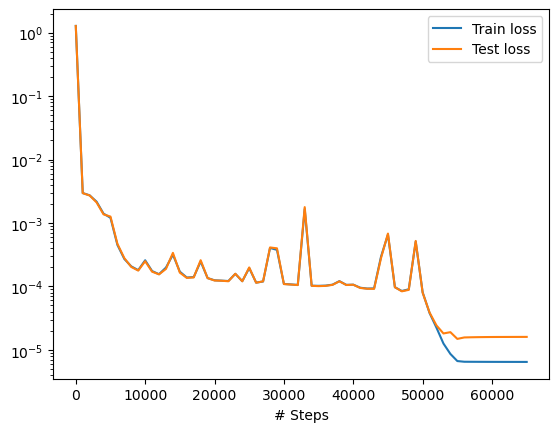

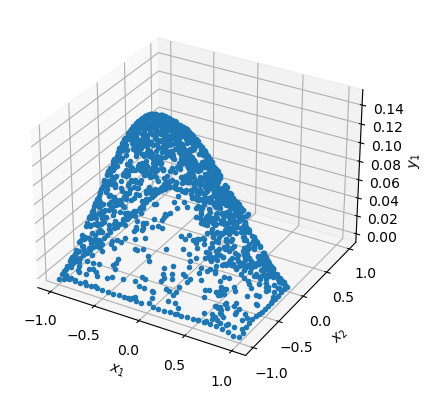

In [14]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

# References

[1] LU LU. DEEPXDE: A DEEP LEARNING LIBRARY FOR SOLVING DIFFERENTIAL EQUATIONS

[2] STEFANO MARKIDIS. The Old and the New: Can Physics-Informed Deep-Learning Replace
Traditional Linear Solvers?
